# Tiny model for CIFAR10

## Configuration

Imports

In [1]:
import warnings

In [2]:
warnings.simplefilter('ignore')

In [3]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

import tqdm
import tqdm.autonotebook
tqdm.autonotebook.tqdm = tqdm.tqdm # hack to force ASCII output everywhere
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms.v2 as transforms

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
import ignite.metrics
import ignite.contrib.handlers

Configuration

In [4]:
DATA_DIR='./data'

NUM_CLASSES = 10
NUM_WORKERS = 8
BATCH_SIZE = 32
EPOCHS = 2000
LEARNING_RATE = 1e-2
WEIGHT_DECAY = 1e-3

In [5]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)

device: cuda


## Data

In [6]:
train_transform = transforms.Compose([
    transforms.ToImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4, fill=127),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToDtype(torch.float, scale=True),
    transforms.RandomErasing(p=0.5, value=0.5)
])

In [7]:
val_transform = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float, scale=True),
])

In [8]:
train_dset = datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=train_transform)
test_dset = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=val_transform)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [10]:
def dataset_show_image(dset, idx):
    X, Y = dset[idx]
    title = "Ground truth: {}".format(dset.classes[Y])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_axis_off()
    ax.imshow(np.moveaxis(X.numpy(), 0, -1))
    ax.set_title(title)
    plt.show()

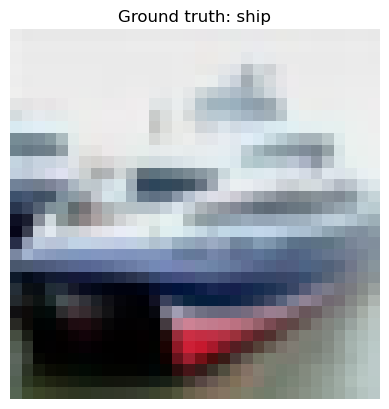

In [11]:
dataset_show_image(test_dset, 1)

## Model

In [12]:
class NormAct(nn.Sequential):
    def __init__(self, channels):
        super().__init__(
            nn.BatchNorm2d(channels),
        	nn.ReLU(inplace=True)
        )

In [13]:
class ResidualBlock(nn.Module):
    def __init__(self, channels, stride=1, p_drop=0.):
        super().__init__()
        self.shortcut = nn.Dropout(p_drop)
        if stride > 1:
            self.shortcut = nn.Sequential(
                nn.Conv2d(channels, channels, stride, stride=stride, groups=channels, bias=False),
                self.shortcut
            )
        self.residual = nn.Sequential(
            NormAct(channels),
            nn.Conv2d(channels, channels, 2 + stride, stride=stride, padding=1, groups=channels, bias=False),
            NormAct(channels),
            nn.Conv2d(channels, channels, 1, bias=False),
        )
        self.γ = nn.Parameter(torch.tensor(0.))

    def forward(self, x):
        out = self.shortcut(x) + self.γ * self.residual(x)
        return out

In [14]:
class Head(nn.Sequential):
    def __init__(self, channels, classes, p_drop=0.):
        super().__init__(
            NormAct(channels),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(p_drop),
            nn.Linear(channels, classes)
        )

In [15]:
def Stem(in_channels, out_channels):
    return nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False)

In [16]:
class Net(nn.Sequential):
    def __init__(self, classes, width=32, in_channels=3, res_p_drop=0., head_p_drop=0.):
        strides = [1, 2, 1, 2, 1, 2, 1]
        super().__init__(
            Stem(in_channels, width),
            *[ResidualBlock(width, stride=stride, p_drop=res_p_drop) for stride in strides],
            Head(width, classes, p_drop=head_p_drop)
        )

In [17]:
def reset_parameters(model):
    for m in model.modules():
        if isinstance(m, (nn.Linear, nn.Conv2d)):
            nn.init.xavier_normal_(m.weight)
            if m.bias is not None: nn.init.zeros_(m.bias)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1.)
            nn.init.zeros_(m.bias)
        elif isinstance(m, ResidualBlock):
            nn.init.zeros_(m.γ)

In [18]:
model = Net(NUM_CLASSES, width=96, res_p_drop=0.1, head_p_drop=0.1).to(DEVICE)

In [19]:
reset_parameters(model)

In [20]:
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

Number of parameters: 80,177


## Training

### Trainer setup

Trainer

In [21]:
loss = nn.CrossEntropyLoss()

In [22]:
params = [p for p in model.parameters() if p.requires_grad]

In [23]:
optimizer = optim.AdamW(params, lr=1e-6, weight_decay=WEIGHT_DECAY)

In [24]:
trainer = create_supervised_trainer(model, optimizer, loss, device=DEVICE,
                                    output_transform=lambda x, y, y_pred, loss: (y_pred, y, loss.item()))

In [25]:
lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE,
                                             steps_per_epoch=len(train_loader), epochs=EPOCHS)

In [26]:
trainer.add_event_handler(Events.ITERATION_COMPLETED, lambda engine: lr_scheduler.step());

In [27]:
ignite.metrics.RunningAverage(output_transform=lambda output: output[2]).attach(trainer, "loss")

In [28]:
ignite.metrics.Accuracy(output_transform=lambda output: (output[0], output[1])).attach(trainer, "accuracy")

In [29]:
pbar = ignite.contrib.handlers.ProgressBar(persist=True, ncols=140)

In [30]:
pbar.attach(trainer, event_name=Events.EPOCH_COMPLETED, closing_event_name=Events.COMPLETED)

Evaluator

In [31]:
val_metrics = {"accuracy": ignite.metrics.Accuracy(), "loss": ignite.metrics.Loss(loss)}

In [32]:
evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=DEVICE)

In [33]:
history = defaultdict(list)

In [34]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    train_state = engine.state
    epoch = train_state.epoch
    max_epochs = train_state.max_epochs
    train_loss = train_state.metrics["loss"]
    train_acc = train_state.metrics["accuracy"]
    history['train loss'].append(train_loss)
    history['train acc'].append(train_acc)
    
    evaluator.run(test_loader)
    val_metrics = evaluator.state.metrics
    val_loss = val_metrics["loss"]
    val_acc = val_metrics["accuracy"]
    history['val loss'].append(val_loss)
    history['val acc'].append(val_acc)

    pbar.pbar.set_postfix({"loss": f"{train_loss:.3f}",
                           "acc": f"{train_acc:.3f}",
                           "val loss": f"{val_loss:.3f}",
                           "val acc": f"{val_acc:.3f}"})

### Start training

In [35]:
trainer.run(train_loader, max_epochs=EPOCHS);

Epoch: [2000/2000] 100%|██████████████████████████████████████████████, loss=0.100, acc=0.964, val loss=0.270, val acc=0.937 [8:54:31<00:00]


In [36]:
def history_plot_train_val(history, key):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    xs = np.arange(1, len(history['train ' + key]) + 1)
    ax.plot(xs, history['train ' + key], '.-', label='train')
    ax.plot(xs, history['val ' + key], '.-', label='val')
    ax.set_xlabel('epoch')
    ax.set_ylabel(key)
    ax.legend()
    ax.grid()
    plt.show()

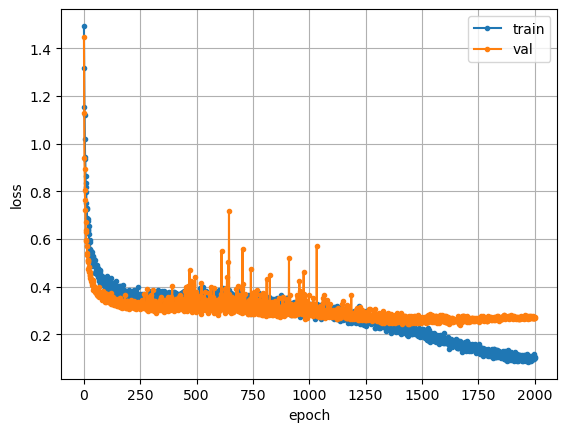

In [37]:
history_plot_train_val(history, 'loss')

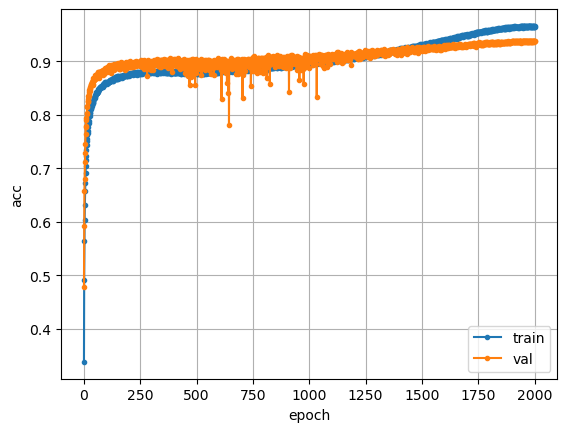

In [38]:
history_plot_train_val(history, 'acc')